# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from maddpg import MADDPG
from buffer import ReplayBuffer
import torch
from collections import namedtuple, deque

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(5):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    step = 0
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        step += 1
        if np.any(dones):                                  # exit loop if episode finished
            print(step)
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

In [ ]:

buffersize = 5000 #change 1000 to 5000
batchsize = 500 #change 100 to 500
buffer = ReplayBuffer(buffersize,batchsize,0)
maddpg = MADDPG(state_size, action_size, num_agents, batchsize ,discount_factor=0.95, tau=0.02,)
uscores = []
plotscores = []
scores_window = deque(maxlen=100)
noise = 2
noise_reduction = 0.9999
for i_episode in range(5000):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        for agent in maddpg.maddpg_agent:
            agent.noise.reset()
        score1 = 0
        score2 = 0
        totscores = np.zeros(num_agents)
        while True:
            actions = maddpg.act(torch.tensor(states, dtype=torch.float),noise)
            noise = noise * noise_reduction
            env_info = env.step(actions)[brain_name]
            actions = np.asarray(actions)
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            buffer.add(states, actions, rewards, next_states,dones)
            states = next_states
            score1 += rewards[0]
            score2 += rewards[1]
            totscores += rewards
            if (len(buffer) > batchsize) and (i_episode % 1 == 0):
                for i in range(num_agents):
                    samples = buffer.sample()
                    maddpg.update(samples, i)
                maddpg.update_targets() 
            if i_episode % 50 == 0:
                torch.save(maddpg.maddpg_agent[0].actor.state_dict(), 'checkpoint_actor1.pth')
                torch.save(maddpg.maddpg_agent[1].actor.state_dict(), 'checkpoint_actor2.pth')
                torch.save(maddpg.maddpg_agent[0].critic.state_dict(), 'checkpoint_critic1.pth')
                torch.save(maddpg.maddpg_agent[1].critic.state_dict(), 'checkpoint_critic2.pth')
            if np.any(dones):
                break
        uscores.append(max(score1, score2))
        scores_window.append(np.max(totscores))
        plotscores.append(np.mean(scores_window))
        print('\rEpisode {}\tAvgScore: {:.4f}\tMaxScore: {:.4f}'.format(i_episode+1, np.mean(scores_window),np.max(totscores)))    
        if np.mean(scores_window) > 0.5:
            torch.save(maddpg.maddpg_agent[0].actor.state_dict(), 'checkpoint_actor1.pth')
            torch.save(maddpg.maddpg_agent[1].actor.state_dict(), 'checkpoint_actor2.pth')
            torch.save(maddpg.maddpg_agent[0].critic.state_dict(), 'checkpoint_critic1.pth')
            torch.save(maddpg.maddpg_agent[1].critic.state_dict(), 'checkpoint_critic2.pth')
            break

#### When finished, you can close the environment.

<IPython.core.display.Javascript object>


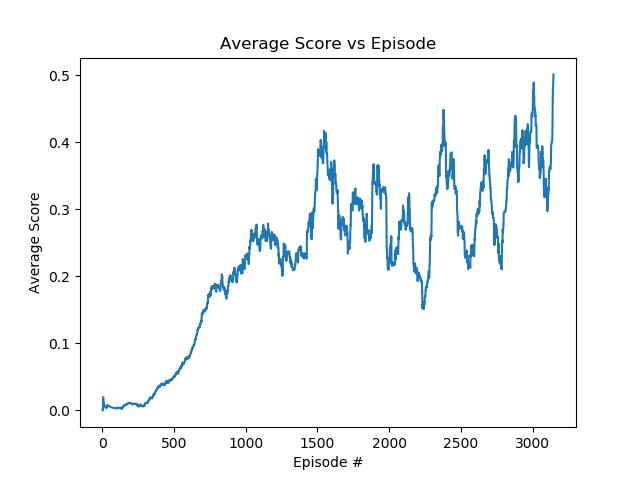

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(1,3147),plotscores)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.title("Average Score vs Episode")
plt.savefig('07262019-01.png',bbox_inches="tight")
plt.show()

In [11]:
#For GIF
for i in range(5):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    step = 0
    while True:
        actions = maddpg.act(torch.tensor(states, dtype=torch.float),noise)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        step += 1
        if np.any(dones):                                  # exit loop if episode finished
            print(step)
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

109
Score (max over agents) from episode 0: 0.30000000447034836
328
Score (max over agents) from episode 1: 0.800000011920929
87
Score (max over agents) from episode 2: 0.20000000298023224
238
Score (max over agents) from episode 3: 0.6000000089406967
13
Score (max over agents) from episode 4: 0.0


In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```